## Using N-Beats to Forecast stock data

<br>


The model architechture is based on the following paper:<br>

https://arxiv.org/abs/1905.10437


Used github for initial implementation of NBEATs Tensorflow code Blocks.<br>
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

**Gather Historical Stock Price Data**
1.   Gather list of S&P 500 companies
2.   Grab a sample of n stocks
3.   Pull Weekly or Daily close price Data




### 5 mins version of forecast

In [3]:
import json, requests
import pandas as pd
import numpy as np
import io
import warnings
warnings.filterwarnings('ignore')

In [5]:
from transform_forecaster import stock_data_pull, fill_blanks, feature_create, change_shape, dataset, window_gen; 
#, data_split

ImportError: cannot import name 'change_shape' from 'transform_functions' (/Users/ozarate/Documents/Demo/loki-investments/transform_functions.py)

In [3]:
import matplotlib as mlab
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import math

# import statsmodels.api as sm    
# import scipy.stats as stats 
# from pylab import rcParams

import sys
from functools import reduce
import itertools
import random

import datetime
from datetime import date, timedelta
from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

# Libraries for stock data
import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

# don't believe I need this for this model build
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv1D,BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential

In [4]:
#import tensorflow_datasets as tfds

### Functions<br>
Functions that couldn't be included in python file at this time

In [5]:
def data_split():
  split_size = int(len(x) * 0.8)
  x_train, y_train = x[:split_size], y[:split_size]
  print('x_train size',len(x_train))
  x_valid, y_valid = x[split_size:], y[split_size:]
  print('x_valide size',len(x_valid))
  # line below is redudant, but keeping it to not change references
  x_valid_true, y_valid_true = x[split_size:], y[split_size:]
  train_ds,valid_ds =  dataset(x_train,y_train,x_valid,y_valid,batch)
  return train_ds,valid_ds, y_valid_true

#### Pull CSV file from end point
- this data will be used for prediction 
- and for picking stocks to include in training

In [6]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tckr = table[0]
# convert to list
basket = tckr.Symbol.unique().tolist()

**Download Stock data**

**Pick start and stop dates**<br>
We will grab most recent stock data<br>
then we will cut into back test and training data<br>
backtesting will be used in the end><br>
recursive process - <br>
there will be a pull done twice. <br>
The second time will have filtered basket set

In [7]:
# Pull stock data for given ticker symvols
stock_total = stock_data_pull(basket,False);


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')


In [8]:
# remove symbols that don't have at least 90 % of max # of observations
# 2 lines below give complete date range
date_range = stock_total.Datetime.drop_duplicates()
date_range = pd.DataFrame(date_range)

In [9]:
count_df = stock_total.groupby('Name').size().reset_index().sort_values(0,ascending=False)
count_df.columns = ['Name','Count']
count_df = count_df[count_df['Count'] > len(date_range)*.9]
tckr_basket_filtered = count_df.Name.tolist()

In [10]:
# list of ticker symbols removed
list(set(basket) - set(tckr_basket_filtered))

['BF.B', 'BRK.B', 'AZO', 'NVR', 'TDY', 'GEHC', 'MTD', 'BIO']

In [11]:
# Pull stock data for given ticker symvols
stock_total = stock_data_pull(tckr_basket_filtered,False);

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')


In [12]:
stock_total.head()

,Datetime,Close,Volume,Name
0,2022-12-12 09:30:00,154.179993,17375,A
1,2022-12-12 09:35:00,154.449997,4558,A
2,2022-12-12 09:40:00,154.339996,7160,A
3,2022-12-12 09:45:00,154.479996,11287,A
4,2022-12-12 09:50:00,154.740005,14116,A


In [13]:
stock_ready = fill_blanks(stock_total,'Name',date_range,'Datetime');

In [14]:
# # checks to ensure if all tckrs have same size
# sizes = stock_ready.groupby('Name').size().unique()
# size_count = sizes.shape[0]

# if size_count == 1:
#   print (f'all good, all data contain {sizes[0]} observations')
# else:
#   print(f'error, your stock contain tckrs with varying number of observations:{sizes}')

# stock_ready.sort_values(by=['Name','Datetime'],inplace=True)
# stock_ready.head()

### Split data for final, out of sample testing<br>
We'll leave over 100 time observations for out of sample validation

In [15]:
# input window and forecast horizon
window = 60
horizon = 12
theta = window+horizon
# out of sample size
oos_size = 100
cut_back = theta + oos_size

In [16]:
# stock_ready.Name.unique()[:10]
# temp.iloc[:-theta,:]
# theta
# temp.iloc[:-theta,:].head()
# temp.iloc[-theta:,:].shape
# temp.iloc[-window:,:].shape
# remove when done 
# temp = stock_ready[stock_ready.Name == 'MMM'].copy()
# temp.shape

In [17]:
stock_train = pd.DataFrame()
stock_test = pd.DataFrame()
#stock_pred = pd.DataFrame()
for i, tckr in enumerate(stock_ready.Name.unique()):
    temp = stock_ready[stock_ready.Name == tckr].copy()
    temp_train = temp.iloc[:-cut_back,:]
    temp_test = temp.iloc[-cut_back:,:]
    if i == 0:
        stock_train = temp_train
        stock_test = temp_test
    else:
        stock_train = pd.concat([stock_train, temp_train  ])
        stock_test = pd.concat([stock_test,temp_test  ])
        
#    stock_train = df_int.append(stock_train,ignore_index=True)
#    stock_test = df_int.append(stock_test,ignore_index=True)

In [18]:
sizes = stock_train.groupby('Name').size().unique()
sizes
# size_count = sizes.shape[0]

array([1439])

### Strategy

For this exercise, we'll be considering historical stock close values . So a univaritate multiseries approach. 

This notebooks looks exclusively at univariate (only past sales data) to forecast.

## Nbeats Implementation

### Model Configuration

In [19]:
# Class to create the block build
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
#               theta_size: int = ,
               
               horizon: int,
               n_neurons: int,
               n_layers: int =4,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.horizon = horizon
    self.theta_size = self.input_size + self.horizon

    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(self.theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

**Training data for N-BEATS**<br>
 Setting up training data for a time series deep learning model is more involved. This is done by using a sliding window, with fixed segments for training and label data. The label data represents the forecast horizon. We slice each series into segments of 80, each with 70 observations for training and 10 for labels. In otherwords, we use the prior 70 days of trading close data to predict the next 10.<br>
 *Note: not only does a single stock generate multiple training data records, the model is also trained using multiple stocks.*

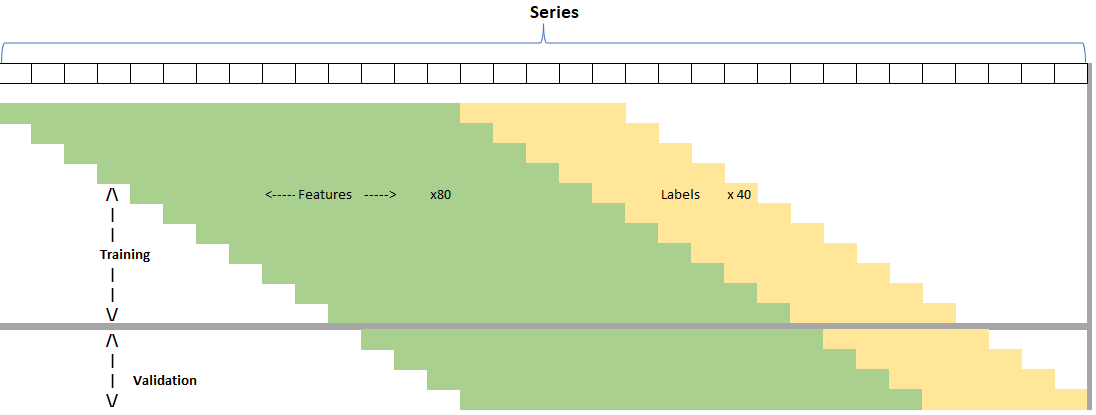

In [20]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D

#epochs = 5000 # called "Iterations" in Table 18
epochs = 500
neurons = 512 # called "Width" in Table 18
block_layers = 4
stacks = 30
#batch = 1024
batch = 256

input_size = window # This should be a multiple of the horizon size.
theta_size = input_size + horizon

input_size, theta_size

(60, 72)

### Data Pipeline
1. For every series, there will be samples generated that include
- features of size window
- & labels of size horizon
2. Then, the sampled data records will be split into training and validation.
3. Then grab the final 'window' number of samples (for example 80) and use this to make final prediction.<br>
  - make sure prediction dates match the expected date range on submission file.
4. Save this prediction   

### Model Build out

In [21]:
%%time
def model_build():
  tf.random.set_seed(48)

  # 1. Setup N-BEATS Block layer
  nbeats_block_layer = NBeatsBlock(input_size=input_size,
  #                                 theta_size=theta_size,
                                  horizon=horizon,
                                  n_neurons=neurons,
                                  n_layers=block_layers,
                                  name="Block_1")

  # 2. Create input to stacks
  stack_input = layers.Input(shape=(input_size), name="stack_input")

  # 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
  backcast, forecast = nbeats_block_layer(stack_input)
  # Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
  residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

  # 4. Create stacks of blocks
  for i, _ in enumerate(range(stacks-1)): # first stack is already creted in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=input_size,
  #      theta_size=theta_size,
        horizon=horizon,
        n_neurons=neurons,
        n_layers=block_layers,
        name=f"NBeatsBlock_{i}"
    )(residuals) # pass it in residuals (the backcast)

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
    
  return nbeats_block_layer, stack_input, backcast, forecast,residuals

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [24]:
nbeats_block_layer, stack_input, backcast, forecast,residuals = model_build()

In [26]:
type(nbeats_block_layer)

__main__.NBeatsBlock

### Data Build

In [27]:
def data_build(srl_num,input_df):
  """
    performs the data build on multiple series
  """
  x, y = [],[]
  #ffeat = dict()  # final prediction features

  for series in input_df[srl_num].unique():
    # eval = []
    temp = input_df[input_df[srl_num] == series].copy()
    ser = change_shape(temp)
    #ffeat[series] = ser[-window:]

    # create two sets of x and y. THe second will be used to generate the true 
    # values to calculate MAE
    ## check if first series, if not append.
    if len(x) > 0: 
      x_temp, y_temp = window_gen(ser,window,horizon)
      for x_array in x_temp:
        x.append(x_array)
      for y_array in y_temp:
        y.append(y_array)
    else: 
      x, y = window_gen(ser,window,horizon)
  return x,y
  #,ffeat

In [28]:
x,y = data_build('Name',stock_train)

In [29]:
len(x)

676665

In [33]:
train_ds,valid_ds, y_valid_true = data_split()

x_train size 541332
x_valide size 135333


In [27]:
# # initiate drive mount 
# drive.mount('/content/gdrive')

In [34]:
def model_create():
  # Put the stack model together
  model = tf.keras.Model(inputs=stack_input, 
                        outputs=forecast, 
                        name="model_N-BEATS")

  # 8. Compile with MAE loss and Adam optimizer
  model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])
  return model

In [ ]:
model = model_create()

### Model fit

In [38]:
%time
history = model.fit(train_ds,
            epochs=epochs,
            validation_data=valid_ds,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1) ])

2023-01-11 19:21:57.303488: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11 19:21:57.303557: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11 19:21:57.303720: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11 19:21:57.303755: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11 19:21:57.303882: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11 19:21:57.303923: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-01-11

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_298' defined at (most recent call last):
    File "/usr/local/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/local/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/local/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_394/1668497740.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', 'history = model.fit(train_ds,\n            epochs=epochs,\n            validation_data=valid_ds,\n            verbose=0, # prevent large amounts of training outputs\n            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time\n            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),\n                                ModelCheckpoint(\'/saved_models/model_{val_loss:.4f}.h5\',\n                                save_best_only=True,\n                                save_weights_only=False,\n                                monitor=\'val_accuracy\') ])\n#              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20, verbose=1) ])\n')
    File "/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2419, in run_cell_magic
      result = fn(*args, **kwargs)
    File "<decorator-gen-54>", line 2, in time
    File "/usr/local/lib/python3.9/site-packages/IPython/core/magic.py", line 187, in <lambda>
      call = lambda f, *a, **k: f(*a, **k)
    File "/usr/local/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1335, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 1, in <module>
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/cdsw/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_298'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_298}}]] [Op:__inference_train_function_35375]

### Model Save

In [37]:
#model.save('/content/gdrive/MyDrive/model_sp_500')
model.save('/saved_models/models2')

PermissionDeniedError: /saved_models; Permission denied

In [ ]:
!ls /content/gdrive/MyDrive/ColabNotebooks/models2

In [ ]:
!cp -r /content/gdrive/MyDrive/models2/ /content/gdrive/MyDrive/

In [ ]:
#reconstructed_model = keras.models.load_model('/content/gdrive/MyDrive/models02')
#recon_model=tf.saved_model.load('/content/gdrive/MyDrive/models/saved_model.pb')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# # copy it there


In [ ]:
!cp -r /content/gdrive/MyDrive/models200/ /content/drive/MyDrive

**Performance**

In [ ]:
type(model)

In [ ]:
type(reconstructed_model)

In [ ]:
metrics = reconstructed_model.evaluate(valid_ds)
#metrics = recon_model.evaluate(valid_ds)


In [ ]:
val_pred = model.predict(valid_ds)
#val_pred = scaler.inverse_transform(val_pred)

In [ ]:
# # builds the array for true values
# %%time 
# empty = 1
# for array in y_valid_true:
#   if empty == 1:
#     Y_true = array.reshape(1,array.shape[0]).copy()
#     empty = 0
#   else:
#     Y_true = np.append(Y_true,array.reshape(1,array.shape[0]),axis=0)

**Validation MAE**
This is for validation set. So there will be 5 validation examples per series. There fore we will take the entire matrix of actual observations and compare to matrix of same size of predictions.

In [ ]:
# #This is the weighte MAE for validation data 
# np.absolute(Y_true - val_pred).mean()

In [ ]:
#losses = history.history['loss']
mae = history.history['mae']
#val_losses = history.history['val_loss']
val_mae = history.history['val_mae']
epochs = len(mae)

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax2 = fig.add_subplot()
ax2.plot(range(epochs), mae, label='Training MAE')
ax2.plot(range(epochs), val_mae, label='Validation MAE')
ax2.set_title('MAE')
ax2.legend()
plt.show()

### Generate Predictions

- Back testing predictions for last h periods<br>
- Run predictions on latest window days<br>


In [ ]:
#repull model 
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

**Prediction File**

In [ ]:

# #today = date.today()
# print("Today's date:", today)

In [ ]:
stock_test.head()

In [ ]:
date_temp = stock_test.Date


In [ ]:
date_temp = date_temp[-horizon:]

In [ ]:
date_list = date_temp.tolist()


In [ ]:
stock_test.head()

#### Generate predictions for Back test

In [ ]:
pred_list = []
for i, tckr in enumerate(stock_test.Name.unique()):
  temp = stock_test[stock_test.Name == tckr].iloc[:window,:].copy()
  x_test_temp = temp.Close.values
  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)
  #x_test_temp, y_test_temp = single_data_build(temp)

  # true values
  temp_true = stock_test[stock_test.Name == tckr].iloc[window:,:].copy
  y_true = temp_true.Close.values

  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)

  pred = model.predict(test)

  pred = pred[:,:horizon][0]
  #stock = tckr
  for i in range(horizon):
    pred_list.append({'stock':tckr,'Date':date_list[i],'Forecasted Close':pred[i],'Actual Close':y_true[i]})


In [ ]:
pred_df = pd.DataFrame(pred_list)

In [ ]:
pred_df.tail()

#### Generate Predictions for actual forecast

In [ ]:
fcast_list = []
for i, tckr in enumerate(stock_test.Name.unique()):
  temp = stock_test[stock_test.Name == tckr].iloc[:window,:].copy()
  x_test_temp = temp.Close.values
  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)
  #x_test_temp, y_test_temp = single_data_build(temp)

  test = x_test_temp.reshape(1,x_test_temp.shape[0],1)

  pred = model.predict(test)

  pred = pred[:,:horizon][0]
  #stock = tckr
  for i in range(horizon):
    fcast_list.append({'stock':tckr,'Date':date_list[i],'Forecasted Close':pred[i])

In [ ]:
fcast_list = pd.DataFrame(pred_list)